In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
# 구글드라이브 연결
from google.colab import drive
drive.mount('/gdrive')
# 데이터파일 불러오기

df = pd.read_csv('/gdrive/My Drive/3-2_machine_learning/image-10k.csv', header=None)

X = df.iloc[:, 1:].values    # 데이터샘플
y = df.iloc[:, 0].values      # 타겟레이블
STEP=3
#RANDOM_STATE=1#1:87.74% 2:87.44% 3:88.14%
score = np.zeros((STEP,))
def state(RANDOM_STATE):

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE, stratify=y)

  import cv2

  hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (7, 7), 9)

                                                       
  hog_x_train = np.zeros((5000,9*4*9),dtype="float64")
  hog_x_test = np.zeros_like(hog_x_train)

  for i in range(5000):
    hog_x_train[i]=hog.compute(x_train[i].reshape(28,28).astype(np.uint8)).squeeze()

  for i in range(5000):
    hog_x_test[i]=hog.compute(x_test[i].reshape(28,28).astype(np.uint8)).squeeze()
  from sklearn.preprocessing import StandardScaler
  
  hog_sc = StandardScaler()
  hog_sc.fit(hog_x_train)
  hog_x_train = hog_sc.transform(hog_x_train)
  hog_x_test = hog_sc.transform(hog_x_test)

  from keras.preprocessing.image import ImageDataGenerator

  
  TOP=0
  ELSE=1

  corse_classify=np.ones_like(y_train)
  test_corse=np.ones_like(y_test)

  corse_classify[y_train==0]=TOP
  corse_classify[y_train==2]=TOP
  corse_classify[y_train==3]=TOP
  corse_classify[y_train==4]=TOP
  corse_classify[y_train==6]=TOP


  test_corse[y_test==0]=TOP
  test_corse[y_test==2]=TOP
  test_corse[y_test==3]=TOP
  test_corse[y_test==4]=TOP
  test_corse[y_test==6]=TOP

  from sklearn.ensemble import VotingClassifier
  from sklearn.datasets import load_breast_cancer
  from sklearn.metrics import accuracy_score
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.neural_network import MLPClassifier
  from sklearn import svm


  svm_clf_1 = svm.SVC(kernel='poly',gamma='auto',probability=True,C=1e1,tol=1e-1,random_state=RANDOM_STATE)
  svm_clf_2 = svm.SVC(kernel='rbf',gamma='auto',probability=True,C=3e0,tol=1e-1,random_state=RANDOM_STATE)

  vo_clf = VotingClassifier(estimators=[('svm1',svm_clf_1),('svm2',svm_clf_2)],  voting='soft')

  vo_clf.fit(hog_x_train, corse_classify)
  pred_y = vo_clf.predict(hog_x_test)
  print('corse 분류기 정확도', accuracy_score(test_corse, pred_y))

  top_x_train=hog_x_train[corse_classify==TOP]
  top_y_train=y_train[corse_classify==TOP]
  top_x_test=hog_x_test[test_corse==TOP]
  top_y_test=y_test[test_corse==TOP]

  from sklearn.neighbors import KNeighborsClassifier

  knn = KNeighborsClassifier(weights='distance',algorithm='auto',p=1,n_neighbors=5)
  mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', batch_size=250,
                      solver='adam', learning_rate="adaptive",  max_iter=500,alpha=5e-1,random_state=RANDOM_STATE)
  svm_clf1 = svm.SVC(kernel='rbf',gamma='scale',probability=True,C=5e1,random_state=RANDOM_STATE)
  svm_clf2 = svm.SVC(kernel='poly',gamma='auto',probability=True,C=1e1,tol=1e-1,random_state=RANDOM_STATE)

  top_clf = VotingClassifier(estimators=[('knn',knn),('mlp', mlp),('svm1',svm_clf1),('svm2',svm_clf2)],  voting='hard')

  top_clf.fit(top_x_train, top_y_train)

  top_pred = top_clf.predict(top_x_test)
  print('top 분류기 정확도', accuracy_score(top_y_test, top_pred))

  else_x_train=hog_x_train[corse_classify==ELSE]
  else_y_train=y_train[corse_classify==ELSE]
  else_x_test=hog_x_test[test_corse==ELSE]
  else_y_test=y_test[test_corse==ELSE]


  knn = KNeighborsClassifier(weights='distance',algorithm='auto',p=1,n_neighbors=3)
  mlp = MLPClassifier(hidden_layer_sizes=(512, 128), activation='relu', batch_size=500,
                      solver='adam', learning_rate="invscaling",  max_iter=250,alpha=1e-2, random_state=RANDOM_STATE)
  svm_clf = svm.SVC(kernel='rbf',gamma='auto',probability=True,C=3e0,tol=1e-1, random_state=RANDOM_STATE)

  else_clf = VotingClassifier(estimators=[('knn', knn),('mlp', mlp),('svm',svm_clf)],  voting='soft')
  else_clf.fit(else_x_train, else_y_train)

  else_pred = else_clf.predict(else_x_test)
  print('else 분류기 정확도', accuracy_score(else_pred,else_y_test))

  test_top_pred=hog_x_test[pred_y==TOP]
  test_top_truth=y_test[pred_y==TOP]

  test_else_pred=hog_x_test[pred_y==ELSE]
  test_else_truth=y_test[pred_y==ELSE]


  top_pred_refine = top_clf.predict(test_top_pred)
  else_pred_refine = else_clf.predict(test_else_pred)

  match=top_pred_refine[top_pred_refine==test_top_truth].shape[0]+else_pred_refine[else_pred_refine==test_else_truth].shape[0]
  print(f"일치율:{match/50}%")#일치율:86.84%
  score[RANDOM_STATE-1] = match/50
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import ConfusionMatrixDisplay

  plt.rcParams['figure.figsize'] = (10,10)

  GT = np.append(test_top_truth, test_else_truth)
  P = np.append(top_pred_refine, else_pred_refine)

  cm = confusion_matrix(GT, P)

  cm = cm / np.repeat(np.bincount(P), 10).reshape(10,10)
  labels = ['T-shirt', 'Trouser', 'Sweater', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
  cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap=plt.cm.Blues)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


corse 분류기 정확도 0.992
top 분류기 정확도 0.8024
else 분류기 정확도 0.964
일치율:87.74%
corse 분류기 정확도 0.989
top 분류기 정확도 0.7968
else 분류기 정확도 0.9696
일치율:87.44%
corse 분류기 정확도 0.9906
top 분류기 정확도 0.8096
else 분류기 정확도 0.9668
일치율:88.14%


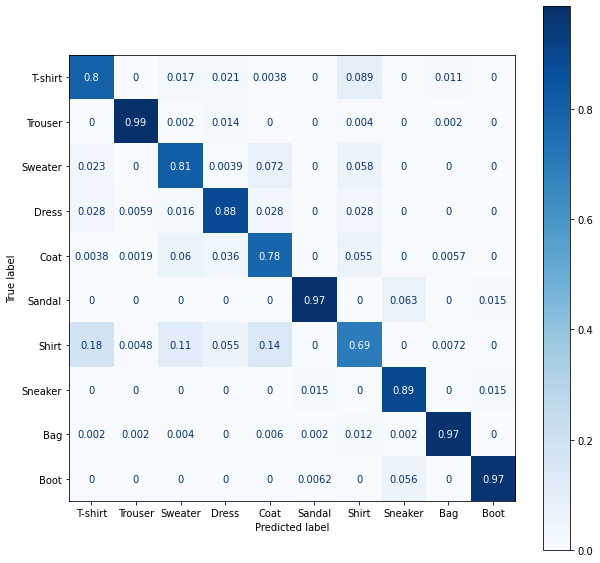

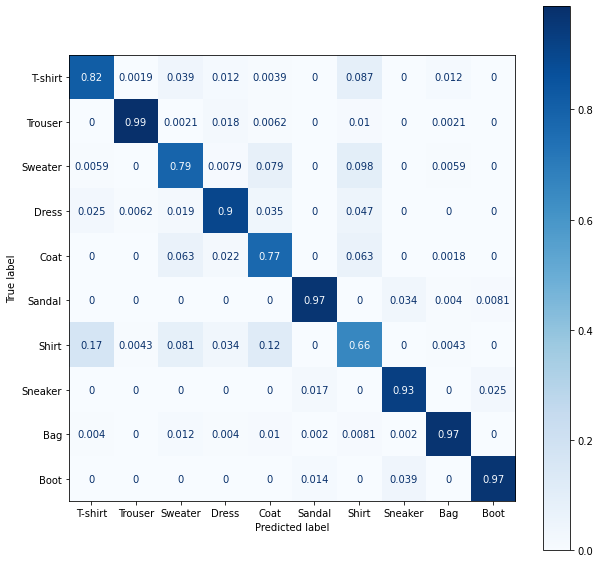

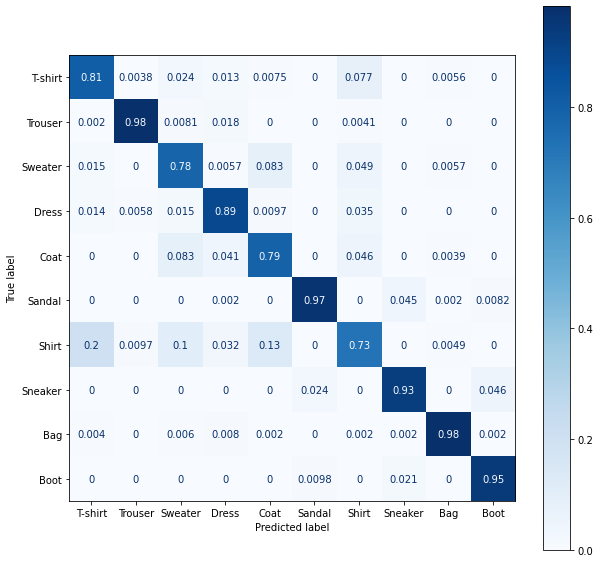

In [7]:
for i in range(STEP):
  state(i+1)

In [9]:
print(f"random state 0,1,2,3,4 에 대한 acc의 평균은 {np.average(score):.2f}%입니다")
print(score)
print(np.max(score))

random state 0,1,2,3,4 에 대한 acc의 평균은 87.77%입니다
[87.74 87.44 88.14]
88.14
